# Monte Carlo methods

I will explore the use of Monte Carlo methods for estimating optimal policies. This follows along with Chapter 5 of [Reinforcement Learning: An Introduction](http://incompleteideas.net/book/the-book.html), which uses Monte Carlo methods to improve policies using the idea of General Policy Iteration (GPI)

I will be basing this on the Blackjack example shown as example 5.1, which uses a simplified version of blackjack to train policies on. Starting out, let's implement the simplified Blackjack environment

In [586]:
import random
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm

# Define the Cards in the deck. Jacks, Queens and Kings all count as 10's
cards = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]

# Now we will create helper functions for playing the game
def draw_card():
    return random.choice(cards)

# Define a State - which is a combination of the dealers shown card, the players current value
# and whether the player has a usable Ace (an Ace that could be either 1 or 11)
class State:
    
    def __init__(self, dealer_card: int, player_value: int, usable_ace: bool, cards = 2):
        self.dealer_card = dealer_card
        self.player_value = player_value
        self.usable_ace = usable_ace
        self.cards = cards
        
    # Add a card to the players value. There are a couple of special cases we need to handle:
    #  - If the player value goes over 21, and the player has a usable ace, we use it to reduce
    #    the player value below the bust limit
    #  - If the card is a 1, we need to assess if the player now has a usable Ace
    # We will return a new instance of State which indicates the state we have moved to with
    # the action
    def hit(self):
        card = draw_card()
        new_state = State(self.dealer_card, self.player_value, self.usable_ace, self.cards + 1)
        
        # For an Ace, either add it as an 11 with the usable ace flag set
        # or add it as just a 1
        if card == 1:
            if self.player_value < 11:
                new_state.player_value = self.player_value + 11
                new_state.usable_ace = True
            else:
                new_state.player_value = self.player_value + 1
        else:
            new_state.player_value = self.player_value + card
        
        # Now the card has been added to the players value, if they are bust and have a usable
        # Ace, we reduce their value so the Ace counts as 1
        if new_state.player_value > 21 and new_state.usable_ace:
            new_state.player_value = new_state.player_value - 10
            new_state.usable_ace = False
            
        return new_state

    # A helper function to show whether the state has bust
    def is_bust(self):
        return self.player_value > 21
    
    def is_natural(self):
        return self.cards == 2 and self.player_value == 21
    
    # Add a hash function so we can use the class as a key for a dict
    def __hash__(self):
        return hash("{0}:{1}:{2}".format(self.dealer_card, self.player_value, self.usable_ace))
    
    def __eq__(self, other):
        return type(other) == type(self) and self.dealer_card == other.dealer_card and self.player_value == other.player_value and self.usable_ace == other.usable_ace

    def __repr__(self):
        return "[{0}, {1}, {2}]".format(self.dealer_card, self.player_value, self.usable_ace)

In [587]:
# Handle the dealers turn. This is based off a defined set of rules: The dealer will always stick on 17 and over
# Otherwise they will hit. This function will return the final value of the dealers hand based off a starting card
def dealer_turn(dealer_card):
    
    # Check if the dealer has a usable ace
    dealer_usable_ace = dealer_card == 1
    dealer_hand = [11 if dealer_card == 1 else dealer_card]

    # Draw until they would stick
    while sum(dealer_hand) < 17:
        dealer_new_card = draw_card()
        
        # Special case for Aces
        if dealer_new_card == 1:
            if sum(dealer_hand) < 11:
                dealer_hand.append(11)
                dealer_usable_ace = True
            else:
                dealer_hand.append(1)
        else:
            dealer_hand.append(draw_card())
            
        # Now the dealer has a hand, if they are bust with a usable ace, convert it from an 11 to a 1
        if sum(dealer_hand) > 21 and dealer_usable_ace:
            dealer_hand.remove(11)
            dealer_hand.append(1)
            dealer_usable_ace = False
        
    return sum(dealer_hand)

# Check if the dealer has a natural 21 (needed if the player has a natural 21)
def does_dealer_natural(dealer_card):
    dealer_hand = [dealer_card, draw_card()]
    dealer_hand = [11 if card == 1 else card for card in dealer_hand]
    return sum(dealer_hand) == 21

# Check if the player wins given they have stuck at a certain state
# We will return the reward of the state after the dealer has drawn
# With Loss = -1, Draw = +0, Win = +1
WIN = 1
DRAW = 0
LOSS = -1
def get_player_reward(state):
    
    # If the player has bust, they lose
    if state.player_value > 21:
        return LOSS

    if state.is_natural():
        # If the player has a natural 21, then they draw if the dealer also
        # has a natural, otherwise the player wins
        if does_dealer_natural(state.dealer_card):
            return DRAW
        else:
            return WIN
        
    # If there is no natural and the player hasn't bust, check if the dealer busts
    dealer_value = dealer_turn(state.dealer_card)
    
    if dealer_value > 21:
        return WIN
    
    # If no-one has bust or got a natural (NOTE: The example makes no note of a dealers 
    # natural when the player doesn't have one), then the larger value wins
    if dealer_value > state.player_value:
        return LOSS
    elif state.player_value > dealer_value:
        return WIN
    else:
        return DRAW

In [588]:
# Get a list of all possible states where decisions matter - if the player has a value under 12, they can always hit
# without concern, so the only player values of note are 12-21
all_states = [State(dealer_card, player_value, usable_ace) 
              for usable_ace in [True, False] 
              for player_value in range(12,22) 
              for dealer_card in range(1,11)]

## Monte Carlo Prediction

Now we have an environment to run an agent against, with states and a reward function, we can try and use the Monte Carlo prediction approach to get a value for each of these states. As no state is ever repeated (the players hand value always increases as they take actions), there is no difference between first-visit & every-visit MC.

We will take the policy that sticks if the player's sum is 20 or 21 (as defined in the example), and hits otherwise. From this policy, we can get a value for each state by randomly choosing a starting state, following the policy until either the player busts or sticks and add the value to the average value of all states visited in the episode.

In [589]:
# Apply policy will take a starting state, and perform an action until it get's to a terminal state.
# Here, the actions are Hit or Stick, the terminal state occurs when either the player sticks or hitting
# results in the player busting
def apply_policy(starting_state):
    states = [starting_state]
    current_state = starting_state
    
    while not current_state.is_bust() and current_state.player_value < 20:
        current_state = current_state.hit()
        states.append(current_state)
    
    return states

def training_episode(starting_state, return_dict):
    training_states = apply_policy(starting_state)
    reward_value = get_player_reward(training_states[-1])
    
    for state in training_states:
        if state in return_dict:
            return_dict[state].append(reward_value)

In [590]:
# Run the training for some number of episodes, starting at a random state for each episode
NUM_EPISODES = 100000
returns = {state: [] for state in all_states}

for i in range(0, NUM_EPISODES):
    starting_state = random.choice(all_states)
    training_episode(starting_state, returns)
    
values = {state: sum(returns[state]) / len(returns[state]) for state in all_states}

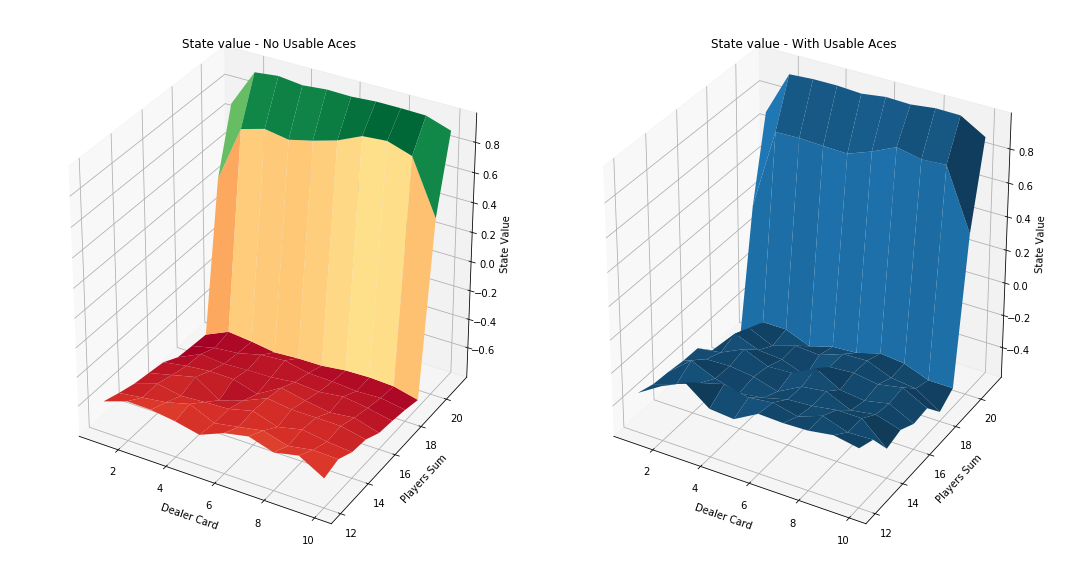

In [591]:
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(121, projection='3d')

dealer_cards = np.arange(1, 11)
player_values = np.arange(12, 22)
reward_value = np.array([values[State(dealer_card, player_value, False)] for player_value in player_values for dealer_card in dealer_cards])

X, Y = np.meshgrid(dealer_cards, player_values)
Z = reward_value.reshape(X.shape)

ax.plot_surface(X, Y, Z, cmap=cm.RdYlGn)

ax.set_title("State value - No Usable Aces")
ax.set_xlabel('Dealer Card')
ax.set_ylabel('Players Sum')
ax.set_zlabel('State Value')

ax2 = fig.add_subplot(122, projection='3d')

ace_reward_value = np.array([values[State(dealer_card, player_value, True)] for player_value in player_values for dealer_card in dealer_cards])

Za = ace_reward_value.reshape(X.shape)

ax2.plot_surface(X, Y, Za)

ax2.set_title("State value - With Usable Aces")
ax2.set_xlabel('Dealer Card')
ax2.set_ylabel('Players Sum')
ax2.set_zlabel('State Value')

plt.tight_layout()
plt.show()


## Monte Carlo Control

Now we can estimate the value of states using Monte Carlo methods, let's use this to learn an approximation of an optimal policy. Using General Policy Improvement (GPI) - we will take a greedy approach to improving policies to converge to an optimal policy. For this approach, we need the value of State-Action pairs, rather than just the value of States. Our policy will then greedily choose the best Action given it's state - this approach generalises well to more complicated problems, with unknown models.

First, we need to start tracking the state-action values instead of the just the state values above:

In [595]:
# Create an Action enum so we can handle the actions generically
from enum import Enum
class Action(Enum):
        STICK = 0
        HIT = 1
        BUST = -1
        
# We will perform an episode which starts at a state, takes an action, then follows a given policy
# We return all state-action pairs we went through in the episode.
# Policy should be a function: (State) => Action
def exploring_starts_policy(starting_state, starting_action, policy):
    state_actions = [(starting_state, starting_action)]
    current_state = starting_state
    
    if starting_action == Action.HIT:
        current_state = current_state.hit()
        
        while not current_state.is_bust():
            next_action = policy(current_state)
            state_actions.append((current_state, next_action))
            if next_action == Action.HIT:
                current_state = current_state.hit()
            else:
                break
                
    if current_state.is_bust():
        state_actions.append((current_state, Action.BUST))
    
    # We have hit a terminal state (either the player bust or stuck)
    return state_actions

# This function will perform a single Monte Carlo episode, given a starting state and starting action, then following the given policy
# until it terminates. We will then update the state-action pairs for all states visited
def state_action_episode(starting_state, starting_action, state_action_values, policy):
    training_state_actions = exploring_starts_policy(starting_state, starting_action, policy)
    reward_value = get_player_reward(training_state_actions[-1][0])
    
    for state_action in training_state_actions:
        state = state_action[0]
        action = state_action[1]
        
#         if state == State(3, 21, True) and action == Action.HIT:
#             print(training_state_actions)
#             print(reward_value)
        
        if state in state_action_values:
            state_action_values[state][action.value].append(reward_value)
            
def greedy_policy(state):
    actions = state_action_values[state]
    stick_rewards = actions[Action.STICK.value]
    hit_rewards = actions[Action.HIT.value]
    
    stick_value = 1 if len(stick_rewards) == 0 else sum(stick_rewards) / len(stick_rewards)
    hit_value = 1 if len(hit_rewards) == 0 else sum(hit_rewards) / len(hit_rewards)
    
    if stick_value > hit_value:
        return Action.STICK
    elif hit_value > stick_value:
        return Action.HIT
    else:
        return random.choice([Action.STICK, Action.HIT])

In [598]:
# Using exploring starts - we will start from a random state & action each episode
# We will train for some number of iterations, and see how our greedy policy develops
NUM_EPISODES = 5000000

# Create a state-action values map. This will map a state to the rewards found for that state for each potential action
# Because there are only two known actions for each state - hit or stick - we can use a 2-tuple to store the rewards for each of these actions.
# The map then looks like:
# {
#    state1: (stick_rewards, hit_rewards),
#    state2: (stick_rewards, hit_rewards),
#    ...
# }
state_action_values = {state: ([], []) for state in all_states}

for i in range(0, NUM_EPISODES):
    state = random.choice(all_states)
    action = random.choice([Action.STICK, Action.HIT])
    
    state_action_episode(state, action, state_action_values, greedy_policy)
    
# Create a final greedy policy
final_policy = {state: greedy_policy(state) for state in all_states}

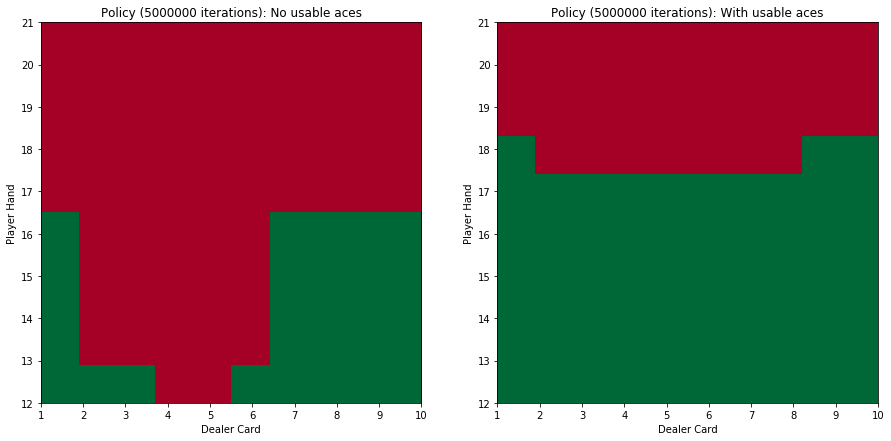

In [599]:
no_aces_policy = [[final_policy[State(x, y, False)].value for x in range(1, 11)] for y in range(21, 11, -1)]
aces_policy = [[final_policy[State(x, y, True)].value for x in range(1, 11)] for y in range(21, 11, -1)]

fig = plt.figure(figsize=(15,8))

ax = fig.add_subplot(121)
ax.imshow(no_aces_policy, extent=[1,10,12,21], cmap=cm.RdYlGn)

ax.set_title("Policy ({0} iterations): No usable aces".format(NUM_EPISODES))
ax.set_xlabel('Dealer Card')
ax.set_ylabel('Player Hand')

ax2 = fig.add_subplot(122)
ax2.imshow(aces_policy, extent=[1,10,12,21], cmap=cm.RdYlGn)

ax2.set_title("Policy ({0} iterations): With usable aces".format(NUM_EPISODES))
ax2.set_xlabel('Dealer Card')
ax2.set_ylabel('Player Hand')

plt.show()